# Feature Extraction

In [1]:
# when running locally
workdir = './'

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)# definindo workdir

workdir = '/content/drive/MyDrive/EP - MAC0417 5768'

ModuleNotFoundError: No module named 'google.colab'

In [2]:
from joblib import load
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops, regionprops_table

meta_set = pd.read_csv(f'{workdir}/classification_dataset.csv')

#imgs = load('images.pkl')
labels = load(f'{workdir}/labels.pkl')
images = load(f'{workdir}/images.pkl')

# extract features from an image
dataset = pd.DataFrame()

for idx, img in enumerate(labels):

    rowset = {'idx': idx, 'class': meta_set['Objeto'].iloc[idx]}
    res = regionprops_table(
        label(img),
        intensity_image=images[idx],
        properties=(
            'area',
            'extent',
            'perimeter',
            'solidity',
            'centroid',
            'orientation',
            'intensity_max',
            'intensity_min',
            'intensity_mean',
            'eccentricity',
            'inertia_tensor',
            'inertia_tensor_eigvals',
            'moments_normalized',
            'moments_weighted_normalized',
            'inertia_tensor_eigvals',
            'eccentricity',
            'centroid_weighted',
            'centroid_weighted_local',
            'equivalent_diameter_area',
            'euler_number',
            'feret_diameter_max',
            'perimeter_crofton',
            'axis_minor_length',
            'axis_major_length'
        )
    )
    rowset.update(res)
    dataset = pd.concat([dataset, pd.DataFrame(rowset)])

# this is the dataset with features
dataset.set_index('idx', drop=True, inplace=True)

In [3]:
# now make it useful
from sklearn.preprocessing import LabelEncoder

lenc = LabelEncoder()
features = [x for x in dataset.columns if x != 'class']

# datasetcopy = dataset.copy(deep=True).fillna(0)
datasetcopy = dataset.copy(deep=True)
X = datasetcopy[features].dropna(axis=1)
y = lenc.fit_transform(dataset['class'])

print(dataset[:100])
print(X[:100])
print(y[:100])


       class   area  extent  perimeter  solidity  centroid-0  centroid-1  \
idx                                                                        
0    celular  12922     1.0      502.0       1.0       130.5       127.0   
1    celular   1326     1.0      142.0       1.0       157.0       129.5   
2    celular   1326     1.0      142.0       1.0       157.0       129.5   
3    celular   1326     1.0      142.0       1.0       156.0       128.5   
4    celular   1326     1.0      142.0       1.0       157.0       129.5   
..       ...    ...     ...        ...       ...         ...         ...   
95   celular   3087     1.0      220.0       1.0       140.0       154.0   
96   celular   2132     1.0      182.0       1.0       146.5       150.0   
97   celular   2132     1.0      182.0       1.0       146.5       150.0   
98   celular   2132     1.0      182.0       1.0       145.5       149.0   
99   celular   2132     1.0      182.0       1.0       146.5       150.0   

     orient

(5008, 53) (2147, 53) (5008,) (2147,)
Best model: {'activation': 'tanh', 'alpha': 0.0001, 'beta_1': 0.8, 'beta_2': 0.9, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 50, 25), 'learning_rate': 'constant', 'momentum': 0.8, 'nesterovs_momentum': True, 'solver': 'adam', 'tol': 0.1}
Score: 0.37307871448532837


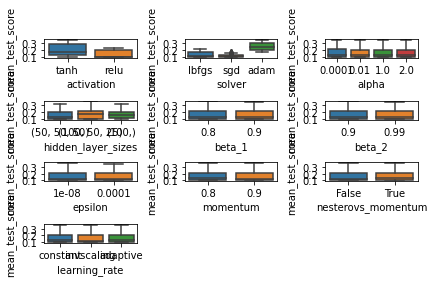

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def filter_df_column_by_list(df, column, values):
  # return df[df[column].str.contains('|'.join(values))]
  # return df[column].query('&'.join(values))
  return df[df[column].isin(values)]

def grid_to_df(grid):
  df = pd.DataFrame(grid.cv_results_)
  df = pd.concat([df, df['params'].apply(pd.Series)], axis=1)
  return df



def neural_network(xtrain, xtest, ytrain, ytest, parameters):
  MLP = MLPClassifier(random_state = 12, max_iter = 100)
  grid = GridSearchCV(MLP, parameters, n_jobs=12)
  grid.fit(xtrain, ytrain)
  print("Best model:", grid.best_params_)
  print("Score:", grid.score(xtest, ytest))
  return grid

parameters_nn = {
    'activation' : ['tanh', 'relu'],
    'solver' : ['lbfgs', 'sgd', 'adam'],
    'alpha' : [1/(10**(2 * x)) for x in range(3)] + [2],
    'hidden_layer_sizes' : [(50,50,50), (100, 50, 25), (100,)],
    
    # adam
    'beta_1' : [0.8, 0.9],
    'beta_2' : [0.9, 0.99],
    'epsilon' : [1e-8, 1e-4],
    
    # sgd
    'momentum' : [0.8, 0.9],
    'nesterovs_momentum' : [True, False],
    'learning_rate' : ['constant', 'invscaling', 'adaptive'],
    
    # optimization
    'tol' : [0.1],
    'early_stopping' : [True]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .7, test_size = .3, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# print(X_train.to_numpy(), X_test, y_train, y_test)
grid_nn = neural_network(X_train.to_numpy(), X_test.to_numpy(), y_train, y_test, parameters_nn)


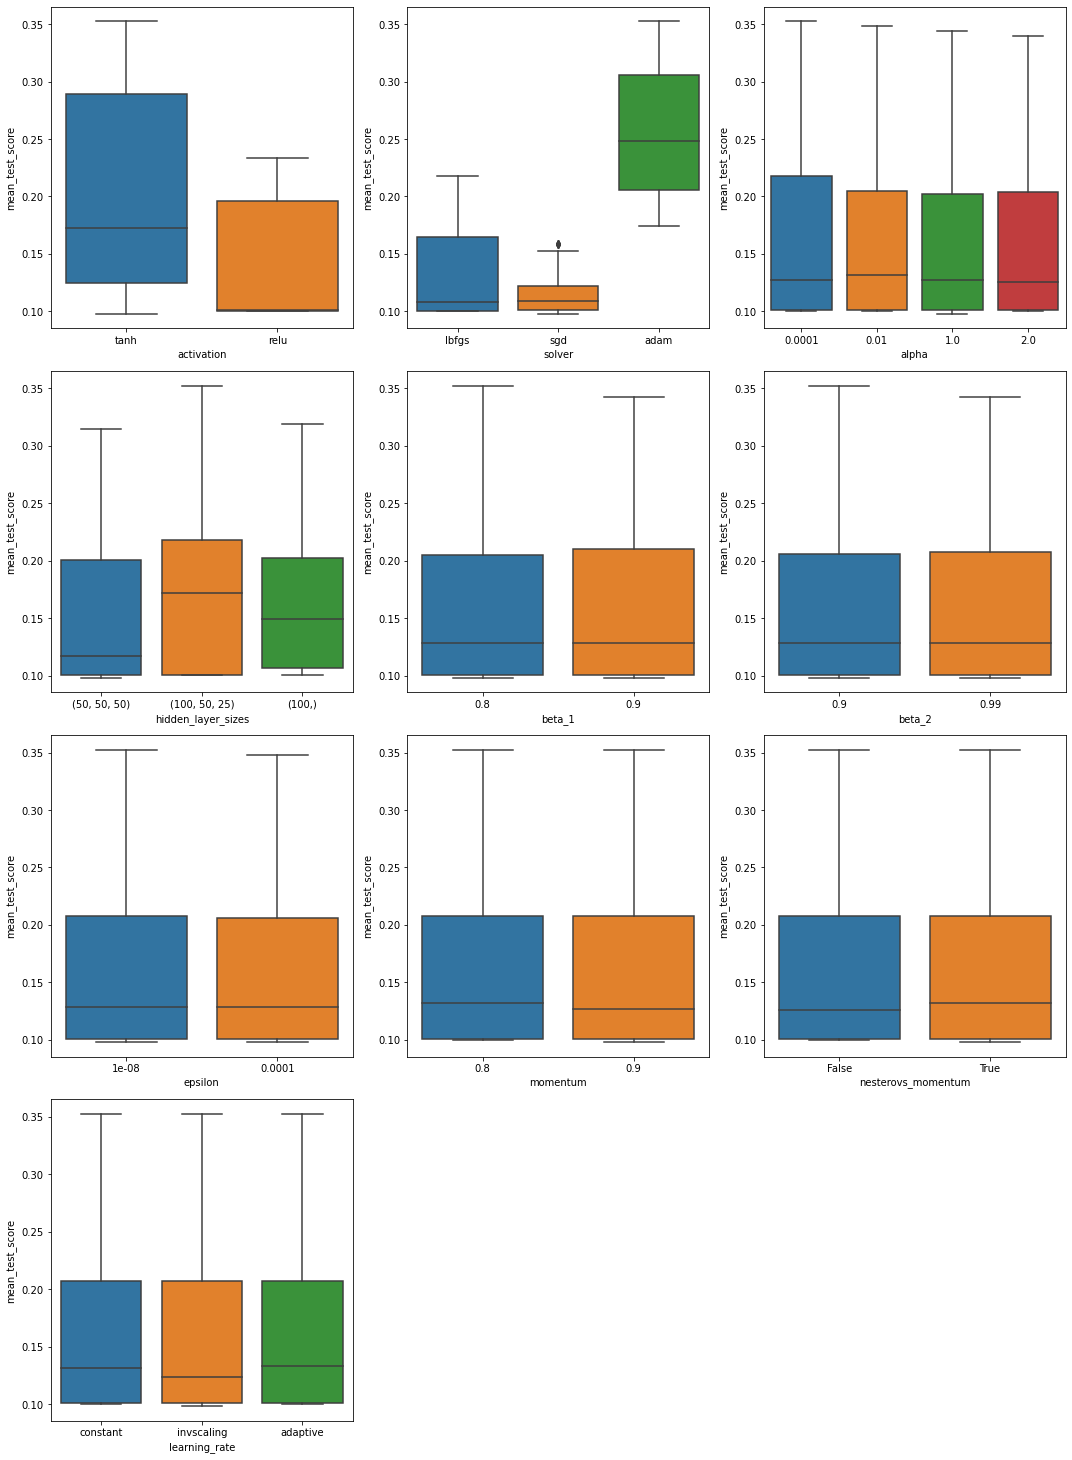

In [14]:
def plot_parameters(grid, parameters):
  counter = 1
  columns = 3
  lines = len(parameters)//columns+1
  plt.rcParams['figure.figsize'] = (5*columns, 5*lines)
  df = grid_to_df(grid)
  for p in parameters.keys():
    v = parameters[p]
    df = filter_df_column_by_list(df, p, v)
  for p in parameters.keys():
    if len(parameters[p]) > 1:
      plt.subplot(lines, columns, counter) 
      sns.boxplot(x = df[p], y=df['mean_test_score'])
      counter += 1
  plt.tight_layout()
  plt.show()
    
plot_parameters(grid_nn, parameters_nn)